In [1]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)
library(tidyr)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
deseq_gundiff = readRDS('../../rds/deseq2_gut_undiff_mockvirus.rds')
genes = read.csv('../../output/gut/gut_genes.csv',row.names = 1)

In [3]:
# Define significance criteria (modify if needed)
lfc_threshold <- 1
padj_threshold <- 0.05

# Extract significantly differentially expressed genes for each virus set
sig_MLB2 <- rownames(deseq_gundiff$MLB2)[
  which(abs(deseq_gundiff$MLB2$log2FoldChange) > lfc_threshold &
        deseq_gundiff$MLB2$padj < padj_threshold)
]

sig_VA1 <- rownames(deseq_gundiff$VA1)[
  which(abs(deseq_gundiff$VA1$log2FoldChange) > lfc_threshold &
        deseq_gundiff$VA1$padj < padj_threshold)
]

sig_HAstV4 <- rownames(deseq_gundiff$HAstV4)[
  which(abs(deseq_gundiff$HAstV4$log2FoldChange) > lfc_threshold &
        deseq_gundiff$HAstV4$padj < padj_threshold)
]


In [4]:
# Find the common genes across all three virus conditions
#Reduce(intersect, list(...)) takes the intersection across all lists, resulting in the genes that are significantly differentially expressed in all three virus conditions.
common_genes <- Reduce(intersect, list(sig_MLB2, sig_VA1, sig_HAstV4))

# Display the common genes
print(common_genes)


[1] "ENSG00000160781" "ENSG00000137959" "ENSG00000128536" "ENSG00000126787"
[5] "ENSG00000176749" "ENSG00000101347"


In [6]:
# Create a summary data frame for the common genes
common_summary <- data.frame(
  gene_id = common_genes,
  MLB2_log2FC = deseq_gundiff$MLB2[common_genes, "log2FoldChange"],
  VA1_log2FC = deseq_gundiff$VA1[common_genes, "log2FoldChange"],
  HAstV4_log2FC = deseq_gundiff$HAstV4[common_genes, "log2FoldChange"]
)

# Add the gene names from the 'genes' data frame.
# We assume the row names of 'genes' match the gene IDs.
common_summary$gene_name <- genes[common_summary$gene_id, "gene_name"]

# Display the summary
print(common_summary)


          gene_id MLB2_log2FC VA1_log2FC HAstV4_log2FC gene_name
1 ENSG00000160781    6.440680   5.872368      6.940963     PAQR6
2 ENSG00000137959    2.864127   8.755425     10.356549    IFI44L
3 ENSG00000128536    6.680516   6.484267      5.966704     CDHR3
4 ENSG00000126787    5.241779   4.031327      4.913290    DLGAP5
5 ENSG00000176749    5.579616   4.809194      5.286932    CDK5R1
6 ENSG00000101347   -1.040909   1.400012      2.806152    SAMHD1


In [7]:
#write.csv(common_summary, file = "gundiff_common_genes_summary.csv", row.names = FALSE)

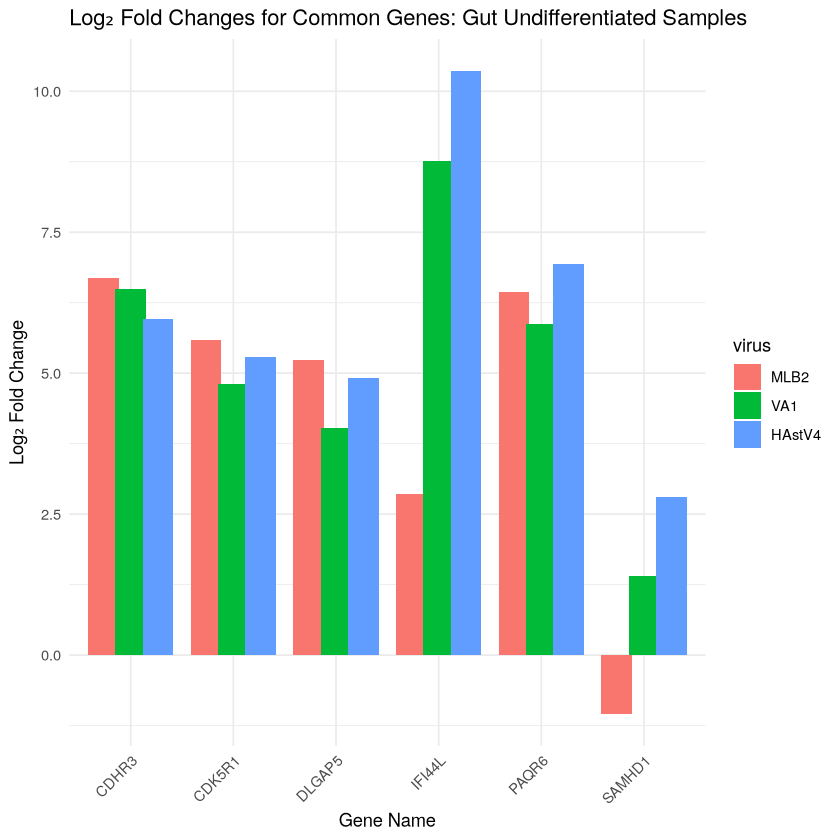

In [10]:
# Reshape data into long format
common_summary_long <- pivot_longer(common_summary,
  cols = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  names_to = "virus",
  values_to = "log2FC"
)

# Clean up virus names
common_summary_long$virus <- factor(common_summary_long$virus,
  levels = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  labels = c("MLB2", "VA1", "HAstV4")
)

# Create the plot
p <- ggplot(common_summary_long, aes(x = gene_name, y = log2FC, fill = virus)) +
  geom_bar(stat = "identity", position = position_dodge(0.8)) +
  theme_minimal() +
  labs(title = "Log₂ Fold Changes for Common Genes: Gut Undifferentiated Samples",
       x = "Gene Name", y = "Log₂ Fold Change") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p)

#Save the plot as PNG
#ggsave("common_genes_plot.png", p, width = 8, height = 6, dpi = 300)

In [11]:
#Save the plot as PNG
ggsave("gundiff_common_genes_plot.png", p, width = 8, height = 6, dpi = 300)

In [12]:
print (common_genes)

[1] "ENSG00000160781" "ENSG00000137959" "ENSG00000128536" "ENSG00000126787"
[5] "ENSG00000176749" "ENSG00000101347"


In [13]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
deseq_gdiff = readRDS('../../rds/deseq2_gut_diff_mockvirus.rds')

In [14]:
# Create summary for gut differentiated
gdiff_summary <- data.frame(
  gene_id = common_genes,
  MLB2_log2FC = deseq_gdiff$MLB2[common_genes, "log2FoldChange"],
  VA1_log2FC  = deseq_gdiff$VA1[common_genes, "log2FoldChange"],
  HAstV4_log2FC = deseq_gdiff$HAstV4[common_genes, "log2FoldChange"]
)

# Create summary for brain
brain_summary <- data.frame(
  gene_id = common_genes,
  MLB2_log2FC = deseq_brain$MLB2[common_genes, "log2FoldChange"],
  VA1_log2FC  = deseq_brain$VA1[common_genes, "log2FoldChange"],
  HAstV4_log2FC = deseq_brain$HAstV4[common_genes, "log2FoldChange"]
)

# Add gene names using your 'genes' data frame
gdiff_summary$gene_name <- genes[gdiff_summary$gene_id, "gene_name"]
brain_summary$gene_name <- genes[brain_summary$gene_id, "gene_name"]

# View the tables
print(gdiff_summary)
print(brain_summary)

          gene_id MLB2_log2FC VA1_log2FC HAstV4_log2FC gene_name
1 ENSG00000160781  0.03783168  0.1950931     0.6978166     PAQR6
2 ENSG00000137959  4.00553765 11.2435163    11.2551448    IFI44L
3 ENSG00000128536 -0.11096954  0.9001063    -0.2277427     CDHR3
4 ENSG00000126787 -2.41744970 -1.6425757    -1.6126310    DLGAP5
5 ENSG00000176749 -1.22475856 -6.2010052    -0.8895694    CDK5R1
6 ENSG00000101347 -0.74087576  3.0700376     3.4101396    SAMHD1
          gene_id MLB2_log2FC  VA1_log2FC HAstV4_log2FC gene_name
1 ENSG00000160781  0.26230358  0.29264830    0.02767127     PAQR6
2 ENSG00000137959  0.18999728  0.19875063   -0.05906427    IFI44L
3 ENSG00000128536  0.92415070  0.41383324    0.91079379     CDHR3
4 ENSG00000126787  0.07154871 -0.32041835   -0.21255631    DLGAP5
5 ENSG00000176749  0.15268222 -0.03124536   -0.08066404    CDK5R1
6 ENSG00000101347 -1.03775858 -0.44551051   -0.51343389    SAMHD1


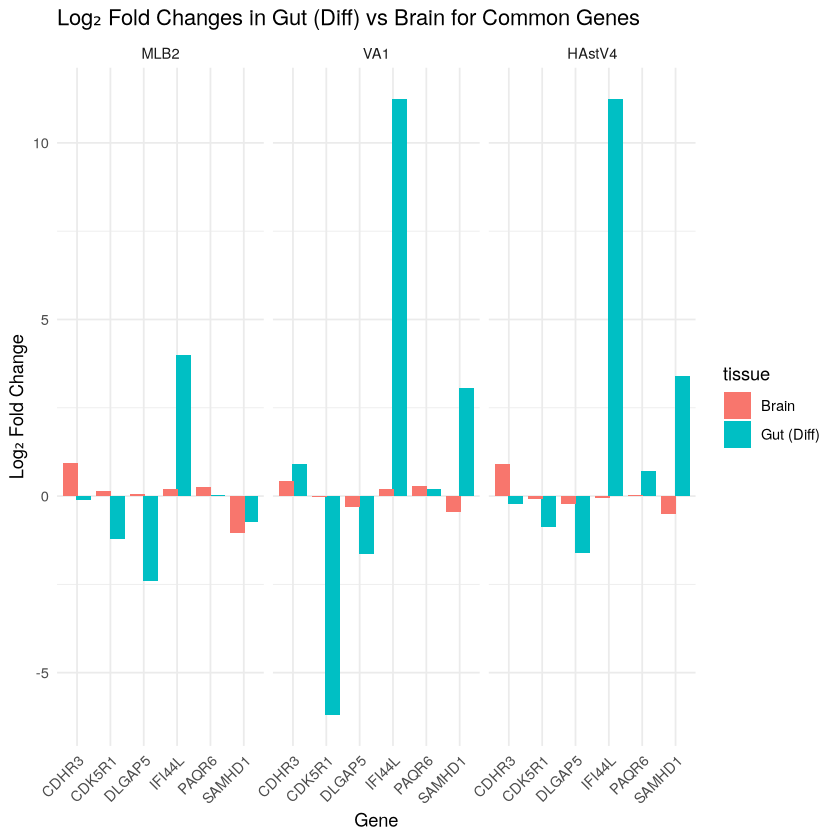

In [15]:
library(ggplot2)
library(tidyr)
library(dplyr)

# Combine both summaries and add a "tissue" column
gdiff_summary$tissue <- "Gut (Diff)"
brain_summary$tissue <- "Brain"

# Bind them together
combined_summary <- bind_rows(gdiff_summary, brain_summary)

# Pivot to long format for plotting
long_combined <- combined_summary %>%
  pivot_longer(
    cols = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
    names_to = "virus",
    values_to = "log2FC"
  )

# Clean virus names
long_combined$virus <- factor(long_combined$virus,
                              levels = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
                              labels = c("MLB2", "VA1", "HAstV4"))

# Plot
p <- ggplot(long_combined, aes(x = gene_name, y = log2FC, fill = tissue)) +
  geom_bar(stat = "identity", position = position_dodge(0.8)) +
  facet_wrap(~virus) +
  theme_minimal() +
  labs(
    title = "Log₂ Fold Changes in Gut (Diff) vs Brain for Common Genes",
    x = "Gene",
    y = "Log₂ Fold Change"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Show the plot
print(p)

# Save it
#ggsave("gut_vs_brain_common_genes.png", p, width = 10, height = 6, dpi = 300)


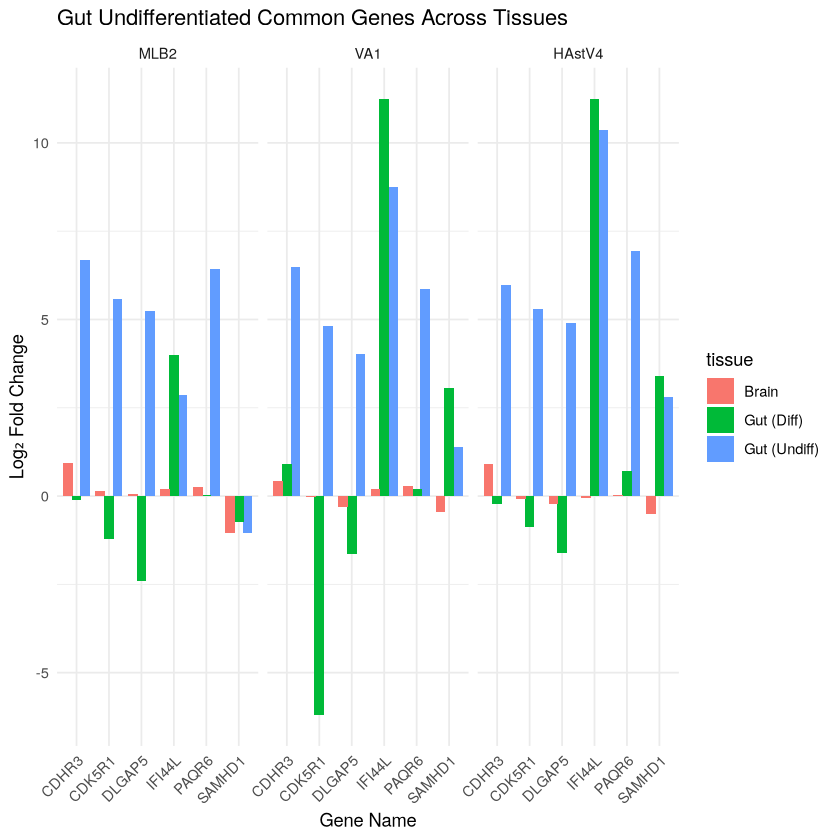

In [16]:
library(dplyr)
library(tidyr)
library(ggplot2)

# Add tissue labels
common_summary$tissue <- "Gut (Undiff)"
gdiff_summary$tissue <- "Gut (Diff)"
brain_summary$tissue <- "Brain"

# Combine all summaries
combined_summary <- bind_rows(common_summary, gdiff_summary, brain_summary)

# Reshape to long format
combined_long <- pivot_longer(combined_summary,
  cols = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  names_to = "virus",
  values_to = "log2FC"
)

# Clean up virus names
combined_long$virus <- factor(combined_long$virus,
  levels = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  labels = c("MLB2", "VA1", "HAstV4")
)

# Create the plot
p <- ggplot(combined_long, aes(x = gene_name, y = log2FC, fill = tissue)) +
  geom_bar(stat = "identity", position = position_dodge(0.8)) +
  facet_wrap(~virus) +
  theme_minimal() +
  labs(title = "Gut Undifferentiated Common Genes Across Tissues",
       x = "Gene Name", y = "Log₂ Fold Change") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Show plot
print(p)

# Save plot
#ggsave("common_genes_all_tissues.png", p, width = 10, height = 6, dpi = 300)


In [17]:
ggsave("Gundiff_common_genes_in_all_tissues.png", p, width = 10, height = 6, dpi = 300)